Run this notebook in a Jupyter environment. If libraries are missing, install them first (see the pip cell below).

> !pip install numpy pandas matplotlib scipy seaborn PyPortfolioOpt




# Portfolio Risk & Performance Measures — Quantitative Notebook

This notebook is an enhanced, runnable reference covering **core portfolio measures**, visualizations, an **efficient frontier** example, **tracking error / information ratio**, and a **Monte Carlo simulation** for forward-looking risk. Use it as part of your quant portfolio project or interview demo.



In [19]:
# Imports and synthetic data generation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats


In [20]:

# For efficient frontier (PyPortfolioOpt)
try:
    from pypfopt.expected_returns import mean_historical_return
    from pypfopt.risk_models import CovarianceShrinkage
    from pypfopt.efficient_frontier import EfficientFrontier
    PYPFO_AVAILABLE = True
except Exception:
    PYPFO_AVAILABLE = False

plt.rcParams['figure.figsize'] = (10,6)

# Create synthetic daily returns for 5 assets (2 years ~ 504 business days)
np.random.seed(42)
dates = pd.date_range(start='2021-01-01', periods=504, freq='B')

n_assets = 5
mu_daily = np.array([0.0006, 0.0004, 0.0005, 0.0003, 0.00045])  # daily means
sigma_daily = np.array([0.012, 0.015, 0.01, 0.02, 0.013])         # daily vol

# Build correlated returns via Cholesky
corr = np.array([[1.0, 0.4, 0.2, 0.1, 0.3],
                 [0.4, 1.0, 0.25, 0.05, 0.35],
                 [0.2, 0.25, 1.0, 0.1, 0.2],
                 [0.1, 0.05, 0.1, 1.0, 0.05],
                 [0.3, 0.35, 0.2, 0.05, 1.0]])

cov = np.outer(sigma_daily, sigma_daily) * corr
L = np.linalg.cholesky(cov)

returns = np.dot(np.random.normal(size=(len(dates), n_assets)), L.T) + mu_daily
returns = pd.DataFrame(returns, index=dates, columns=[f"Asset_{i+1}" for i in range(n_assets)])

# Convert to price series with initial price 100
prices = (1 + returns).cumprod() * 100

# Display head
returns.head()


,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5
2021-01-01,0.006561,0.001479,0.007468,0.032519,0.000156
2021-01-04,-0.002210,0.020706,0.010344,-0.007890,0.012055
2021-01-05,-0.004961,-0.008783,0.001037,-0.038281,-0.023328
2021-01-06,-0.006147,-0.016898,0.000520,-0.018545,-0.021564
2021-01-07,0.018188,0.006090,0.003662,-0.024965,-0.001137



## 1) Basic Metrics & Visualizations


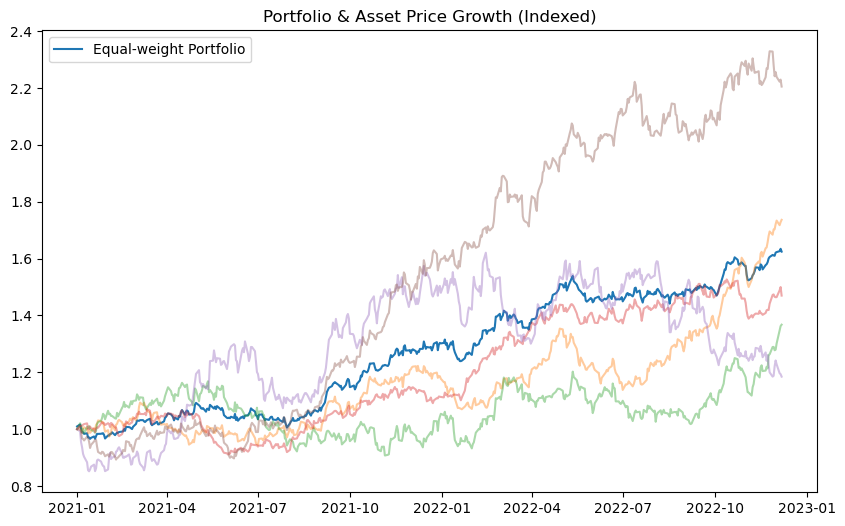

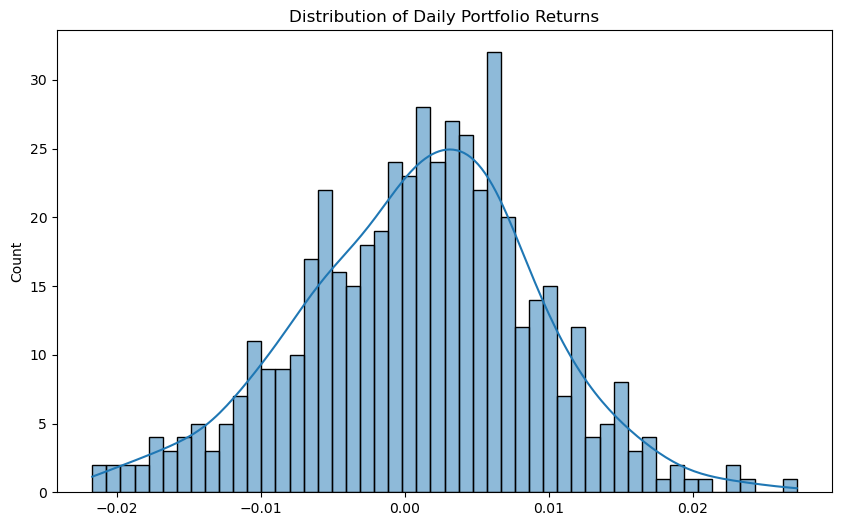

Annualized Return: 25.11%
Annualized Volatility: 12.97%
Sharpe Ratio (rf=0): 1.94


In [21]:
# Annualization factor
TRADING_DAYS = 252

# Portfolio weights example (equal weight)
weights = np.repeat(1/n_assets, n_assets)

# Portfolio daily returns
portfolio_returns = returns.dot(weights)

# Cumulative value (starting at 1)
cum_value = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
plt.figure()
plt.plot(cum_value.index, cum_value.values, label='Equal-weight Portfolio')
for col in prices.columns:
    plt.plot(prices.index, prices[col] / prices[col].iloc[0] , alpha=0.4)
plt.title('Portfolio & Asset Price Growth (Indexed)')
plt.legend()
plt.show()

# Histogram of daily returns
plt.figure()
sns.histplot(portfolio_returns, kde=True, bins=50)
plt.title('Distribution of Daily Portfolio Returns')
plt.show()

# Annualized metrics
ann_return = portfolio_returns.mean() * TRADING_DAYS
ann_vol = portfolio_returns.std() * np.sqrt(TRADING_DAYS)
sharpe = ann_return / ann_vol

print(f"Annualized Return: {ann_return:.2%}")
print(f"Annualized Volatility: {ann_vol:.2%}")
print(f"Sharpe Ratio (rf=0): {sharpe:.2f}")


## 2) Drawdown Chart & Max Drawdown


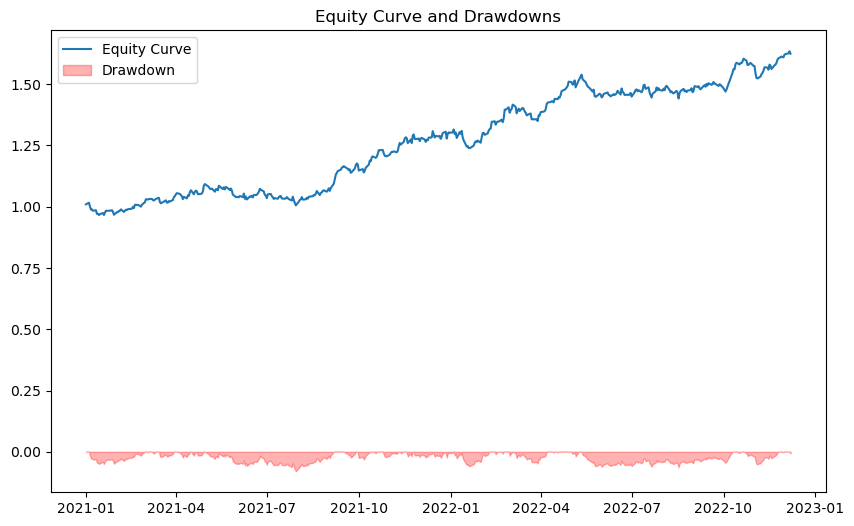

Maximum Drawdown: -7.94%


In [23]:

def compute_drawdown(cum_returns_series):
    running_max = cum_returns_series.cummax()
    drawdown = (cum_returns_series - running_max) / running_max
    return drawdown

cum_port = (1 + portfolio_returns).cumprod()
drawdown = compute_drawdown(cum_port)

plt.figure()
plt.plot(cum_port, label='Equity Curve')
plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3, label='Drawdown')
plt.title('Equity Curve and Drawdowns')
plt.legend()
plt.show()

max_dd = drawdown.min()
print(f"Maximum Drawdown: {max_dd:.2%}")


## 3) Value at Risk (VaR) & CVaR (Historical & Parametric)


In [24]:

alpha = 0.95
# Historical VaR
VaR_hist = -np.percentile(portfolio_returns, (1-alpha)*100)
# Parametric VaR assuming normality
z = norm.ppf(1-alpha)
VaR_param = -(portfolio_returns.mean() + z * portfolio_returns.std())
# CVaR (Expected Shortfall) historical
CVaR_hist = -portfolio_returns[portfolio_returns <= -VaR_hist].mean()

print(f"Historical VaR (95%): {VaR_hist:.2%}")
print(f"Parametric VaR (95%): {VaR_param:.2%}")
print(f"Historical CVaR (95%): {CVaR_hist:.2%}")


Historical VaR (95%): 1.30%
Parametric VaR (95%): 1.24%
Historical CVaR (95%): 1.68%


## 4) Skewness & Kurtosis (Distribution Shape)

Skewness: -0.1363
Kurtosis: 0.1753


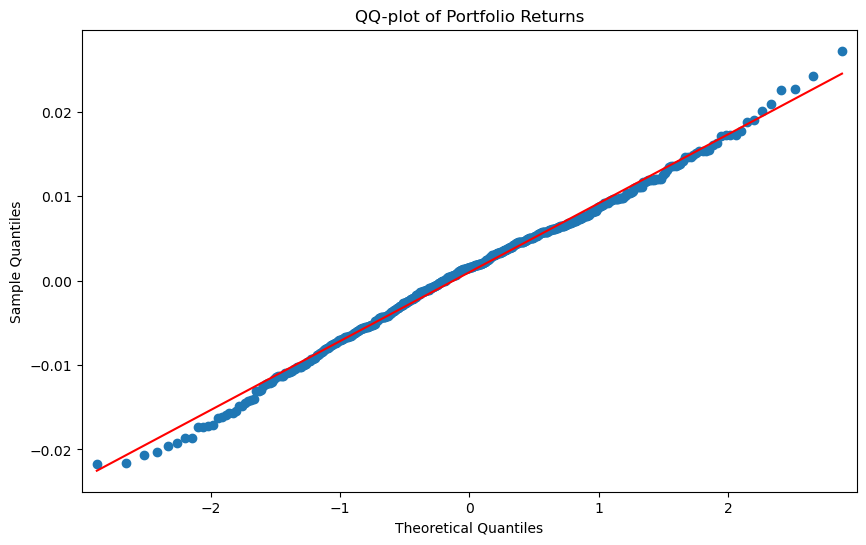

In [25]:
skew = portfolio_returns.skew()
kurt = portfolio_returns.kurtosis()
print(f"Skewness: {skew:.4f}")
print(f"Kurtosis: {kurt:.4f}")

# QQ-plot
import statsmodels.api as sm
sm.qqplot(portfolio_returns, line='s')
plt.title('QQ-plot of Portfolio Returns')
plt.show()


## 5) Tracking Error & Information Ratio (vs Market)


In [26]:
# Simulate a market benchmark as a weighted combination of assets or separate series
market = (0.4*returns['Asset_1'] + 0.6*returns['Asset_2']).rename('Market')

active_returns = portfolio_returns - market
tracking_error = active_returns.std() * np.sqrt(TRADING_DAYS)
excess_ann = (portfolio_returns.mean() - market.mean()) * TRADING_DAYS
information_ratio = excess_ann / tracking_error

print(f"Tracking Error (ann): {tracking_error:.2%}")
print(f"Information Ratio: {information_ratio:.4f}")


Tracking Error (ann): 11.97%
Information Ratio: 0.1686


## 6) Efficient Frontier (using PyPortfolioOpt if available)


Max Sharpe performance:
Return: 37.15%, Vol: 13.81%, Sharpe: 2.69


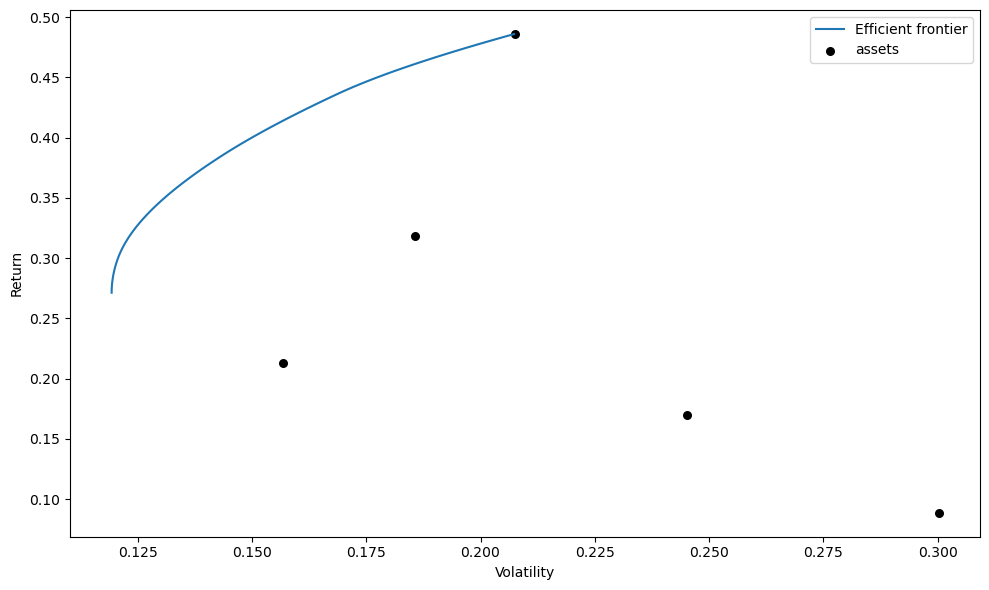

In [29]:
if not PYPFO_AVAILABLE:
    print("PyPortfolioOpt not available. To enable efficient frontier, install pypfopt: pip install PyPortfolioOpt")
else:
    # Expected returns and shrinkage covariance
    mu = mean_historical_return(prices)
    S = CovarianceShrinkage(prices).ledoit_wolf()

    # Create a new EfficientFrontier object
    ef = EfficientFrontier(mu, S)
    
    # Max Sharpe Ratio optimization
    raw_weights = ef.max_sharpe()
    cleaned = ef.clean_weights()
    ret_ann, vol_ann, sharpe_ann = ef.portfolio_performance()

    print("Max Sharpe performance:")
    print(f"Return: {ret_ann:.2%}, Vol: {vol_ann:.2%}, Sharpe: {sharpe_ann:.2f}")

    # Plot efficient frontier
    from pypfopt import plotting
    ef = EfficientFrontier(mu, S) # create a new object for plotting
    plotting.plot_efficient_frontier(ef, show_assets=True)
    plt.show()


## 7) Turnover Calculation Example (over two periods)


In [30]:
# Example previous and new weights
prev_w = np.array([0.2,0.2,0.2,0.2,0.2])
new_w = np.array([0.1,0.3,0.25,0.2,0.15])
turnover = 0.5 * np.sum(np.abs(new_w - prev_w))
print(f"Turnover: {turnover:.2%}")


Turnover: 15.00%


## 8) Monte Carlo Simulation of Portfolio Value


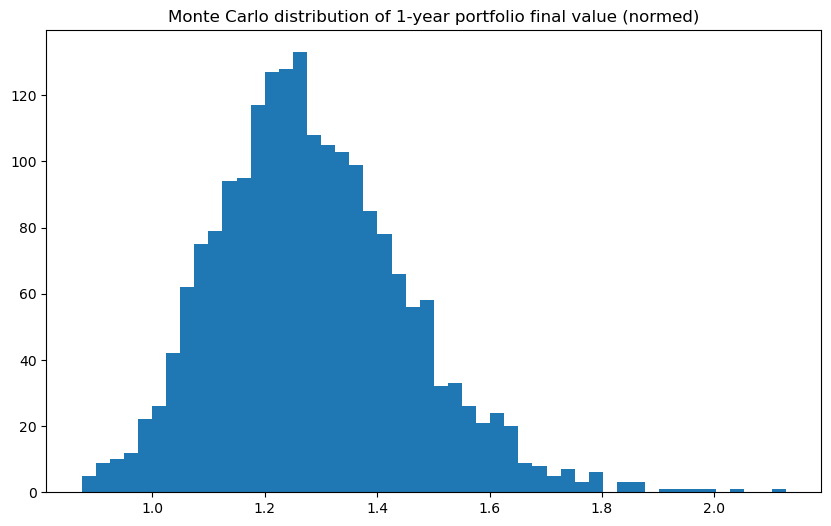

Median final value: 1.269
5th percentile final value: 1.032


In [31]:
# Monte Carlo simulate paths using historical mean and covariance
n_sims = 2000
n_days = 252  # 1 year
np.random.seed(123)

mu = returns.mean().values  # daily mean vector
Sigma = returns.cov().values

# Cholesky for correlating draws
L = np.linalg.cholesky(Sigma)

sim_final_values = []
for sim in range(n_sims):
    vals = np.ones(n_days)  # portfolio value normalized
    w = weights
    daily_prices = np.zeros((n_days, n_assets))
    for t in range(n_days):
        z = np.random.normal(size=n_assets)
        sample = mu + L.dot(z)
        # portfolio return at day t
        r = np.dot(w, sample)
        vals[t] = (1 + r) if t==0 else vals[t-1] * (1 + r)
    sim_final_values.append(vals[-1])

sim_final_values = np.array(sim_final_values)

plt.figure()
plt.hist(sim_final_values, bins=50)
plt.title('Monte Carlo distribution of 1-year portfolio final value (normed)')
plt.show()

print(f"Median final value: {np.median(sim_final_values):.3f}")
print(f"5th percentile final value: {np.percentile(sim_final_values,5):.3f}")


## 9) Putting it together: Summary Table


In [42]:

summary = {
    'Annual Return': ann_return,
    'Annual Volatility': ann_vol,
    'Sharpe': sharpe,
    'Max Drawdown': max_dd,
    'VaR(95%)': VaR_hist,
    'CVaR(95%)': CVaR_hist,
    'Tracking Error': tracking_error,
    'Information Ratio': information_ratio
}

pd.Series(summary)


Annual Return        0.251105
Annual Volatility    0.129709
Sharpe               1.935919
Max Drawdown        -0.079408
VaR(95%)             0.013012
CVaR(95%)            0.016816
Tracking Error       0.119712
Information Ratio    0.168569
dtype: float64


### Next Steps / Extensions
- Add transaction cost modeling and realistic execution assumptions.
- Compute rolling metrics (rolling Sharpe, rolling volatility, rolling drawdown).
- Use bootstrapping to estimate confidence intervals for Sharpe and returns.
- Integrate with your backtest engine (vectorbt/backtrader) to compute realized metrics from signals.



This notebook is designed to give you a **comprehensive reference** for the key metrics used in portfolio management, risk measurement, and performance evaluation. Each section includes:
- **Definition**
- **Mathematical Formula**
- **Python Example** (using `pandas` and `numpy`)


## 1. Portfolio Weights
**Meaning:** The proportion of total capital allocated to each asset.

**Formula:**
\[ w_i = \frac{V_i}{\sum_{j=1}^{n} V_j} \]
where \( V_i \) = value invested in asset i.



In [43]:

import numpy as np
import pandas as pd

values = np.array([40000, 35000, 25000])  # Investment in 3 assets
total = values.sum()
weights = values / total
print("Portfolio Weights:", weights)


Portfolio Weights: [0.4  0.35 0.25]


## 2. Portfolio Return
**Meaning:** Weighted sum of individual asset returns.

**Formula:**
$[ R_p = \sum_{i=1}^{n} w_i R_i]$

In [44]:
returns = np.array([0.05, 0.03, 0.02])  # individual asset returns
portfolio_return = np.dot(weights, returns)
print("Portfolio Return:", portfolio_return)


Portfolio Return: 0.035500000000000004



## 3. Portfolio Variance & Volatility
**Meaning:** Risk of portfolio measured by variance/standard deviation.

**Formula:**
\[ \sigma_p^2 = w^T \Sigma w \]
where \(\Sigma\) = covariance matrix.


In [45]:
cov_matrix = np.array([
    [0.04, 0.01, 0.00],
    [0.01, 0.03, 0.01],
    [0.00, 0.01, 0.02]
])
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility = np.sqrt(portfolio_variance)
print("Portfolio Variance:", portfolio_variance)
print("Portfolio Volatility:", portfolio_volatility)


Portfolio Variance: 0.015875
Portfolio Volatility: 0.12599603168354154


## 4. Value-at-Risk (VaR)
**Meaning:** Maximum expected loss at a given confidence level.

**Formula (Parametric):**
\[ VaR_{\alpha} = Z_{\alpha} \cdot \sigma_p - \mu_p \]



In [46]:
from scipy.stats import norm
confidence = 0.95
z_score = norm.ppf(1-confidence)
VaR = -(portfolio_return + z_score * portfolio_volatility)
print(f"{confidence*100}% VaR:", VaR)


95.0% VaR: 0.1717450296961659


## 5. Expected Shortfall (CVaR)
**Meaning:** Expected loss beyond VaR.

**Formula:**
\[ CVaR = E[L | L > VaR] \]


In [47]:
CVaR = -(portfolio_return + (norm.pdf(z_score)/confidence) * portfolio_volatility)
print(f"{confidence*100}% CVaR:", CVaR)


95.0% CVaR: -0.04917861201309226


## 6. Portfolio Turnover
**Meaning:** Measures how frequently portfolio holdings are changed.

**Formula:**
\[ Turnover = \frac{\sum | w_{i,t} - w_{i,t-1} |}{2} \]


In [48]:
prev_weights = np.array([0.4, 0.3, 0.3])
turnover = np.sum(np.abs(weights - prev_weights)) / 2
print("Portfolio Turnover:", turnover)


Portfolio Turnover: 0.04999999999999999


## 7. Sharpe Ratio
**Meaning:** Measures risk-adjusted return.

**Formula:**
\[ Sharpe = \frac{R_p - R_f}{\sigma_p} \]



In [49]:
risk_free_rate = 0.02
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
print("Sharpe Ratio:", sharpe_ratio)


Sharpe Ratio: 0.12301974747054449


## 8. Sortino Ratio
**Meaning:** Like Sharpe but penalizes only downside volatility.



In [50]:
# Example downside volatility calculation
downside_returns = np.minimum(returns - risk_free_rate, 0)
downside_volatility = np.sqrt(np.mean(downside_returns**2))
sortino_ratio = (portfolio_return - risk_free_rate) / downside_volatility
print("Sortino Ratio:", sortino_ratio)


Sortino Ratio: inf


C:\Users\VAQ\AppData\Local\Temp\ipykernel_7220\4116785194.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  sortino_ratio = (portfolio_return - risk_free_rate) / downside_volatility


## 9. Beta (Systematic Risk)
**Meaning:** Sensitivity of portfolio to market.

**Formula:**
\[ \beta_p = \frac{Cov(R_p, R_m)}{Var(R_m)} \]



In [51]:
market_returns = np.array([0.04, 0.02, 0.01])
portfolio_cov = np.cov(returns, market_returns)[0][1]
market_var = np.var(market_returns)
portfolio_beta = portfolio_cov / market_var
print("Portfolio Beta:", portfolio_beta)


Portfolio Beta: 1.5


## 10. Maximum Drawdown
**Meaning:** Largest peak-to-trough loss.


In [52]:
portfolio_value = pd.Series([100, 105, 103, 98, 102, 97, 110])
roll_max = portfolio_value.cummax()
drawdown = (portfolio_value - roll_max) / roll_max
max_drawdown = drawdown.min()
print("Maximum Drawdown:", max_drawdown)

Maximum Drawdown: -0.0761904761904762
